In [94]:
#!pip install pandas matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal, shapiro
#!pip install scikit-posthocs
import scikit_posthocs as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, pearsonr

In [95]:
# Leitura dos dados
df = pd.read_csv('pandepth.tsv', sep='\t')
df.head()

Fracionamento  R√©plica  Tempo(s)  Mem√≥ria(MB)  Disco(MB)  CPU(%)  Rede(MB)
0            5%        1     19.06       771.40    7424.36   14.42     36.86
1            5%        2     19.06       777.71    7424.40   14.53     36.86
2            5%        3     19.06       761.71    7424.44   14.57     36.86
3            5%        4     19.06       744.95    7424.49   14.62     36.86
4            5%        5     19.06       739.59    7424.54   14.60     36.86

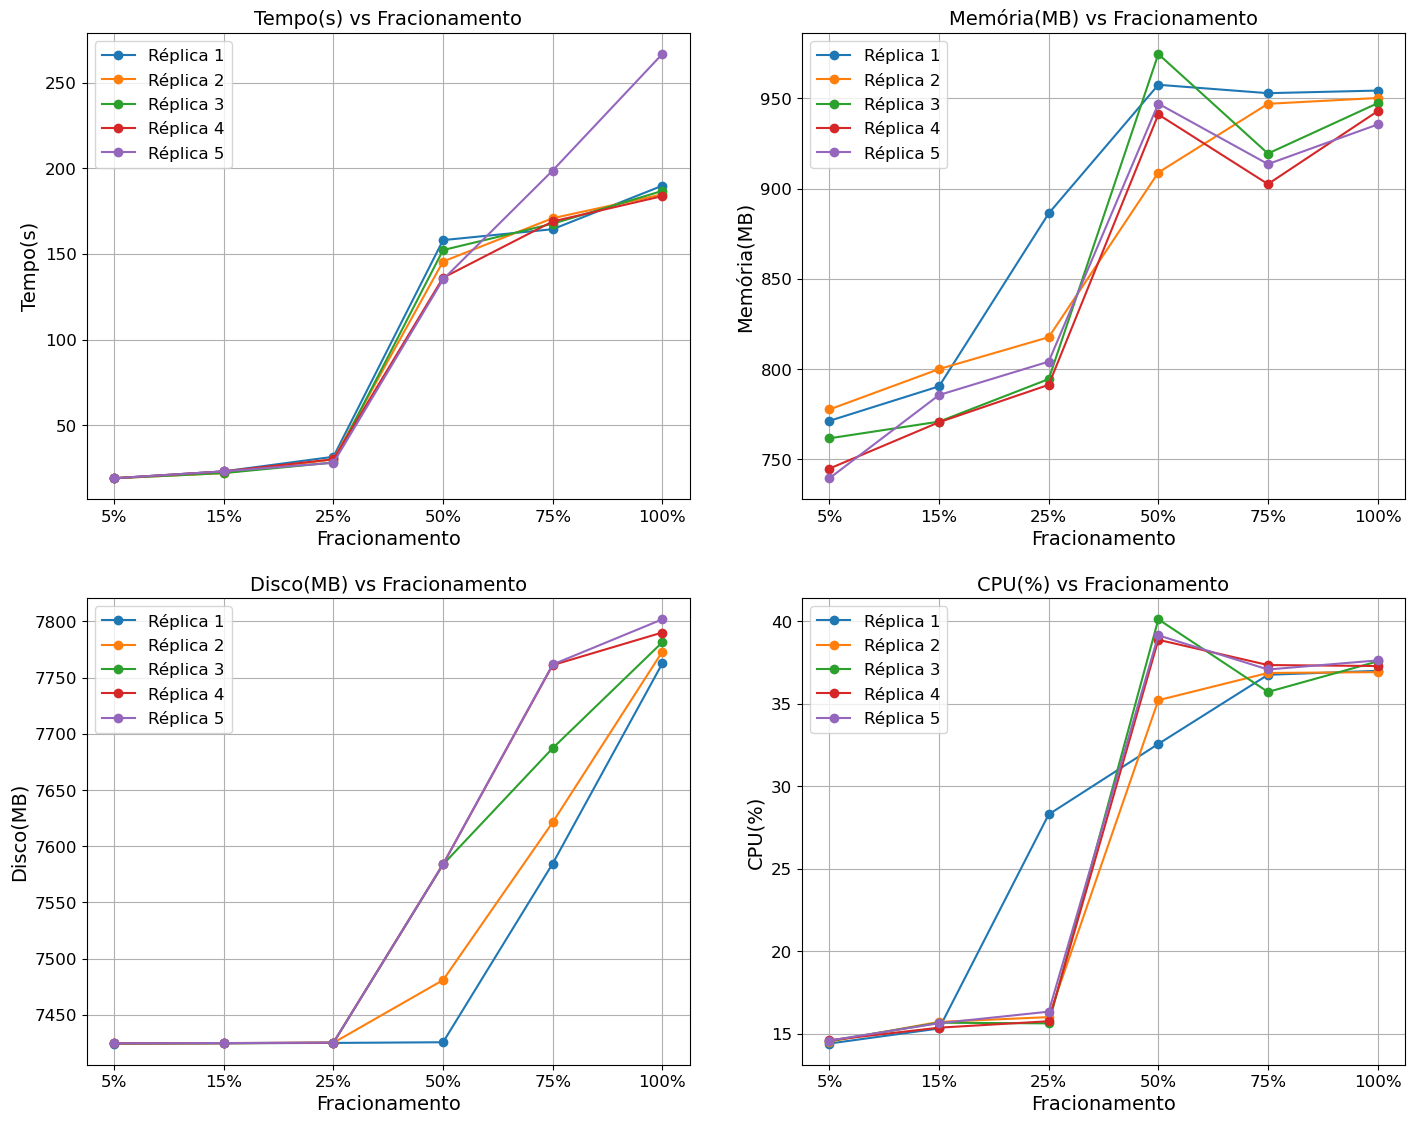

In [ ]:
metrics = ['Tempo(s)','Mem√≥ria(MB)','Disco(MB)','CPU(%)']
fracs = df['Fracionamento'].unique()

# Atualizar os gr√°ficos com as r√©plicas como linhas, organizados em 2 colunas
fig, axs = plt.subplots(len(metrics) // 2 + len(metrics) % 2, 2, figsize=(15, 12))
fig.tight_layout(pad=5.0)

axs = axs.flatten()

for i, metric in enumerate(metrics):
    for replica in df['R√©plica'].unique():
        replica_data = df[df['R√©plica'] == replica]
        axs[i].plot(
            replica_data["Fracionamento"],
            replica_data[metric],
            marker='o',
            label=f"R√©plica {replica}"
        )
    axs[i].set_title(f"{metric} vs Fracionamento", fontsize=14) 
    axs[i].set_xlabel("Fracionamento", fontsize=14)
    axs[i].set_ylabel(metric, fontsize=14)
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].grid(True)
    axs[i].legend(fontsize=12) 


for j in range(len(metrics), len(axs)):
    fig.delaxes(axs[-1])

plt.show()


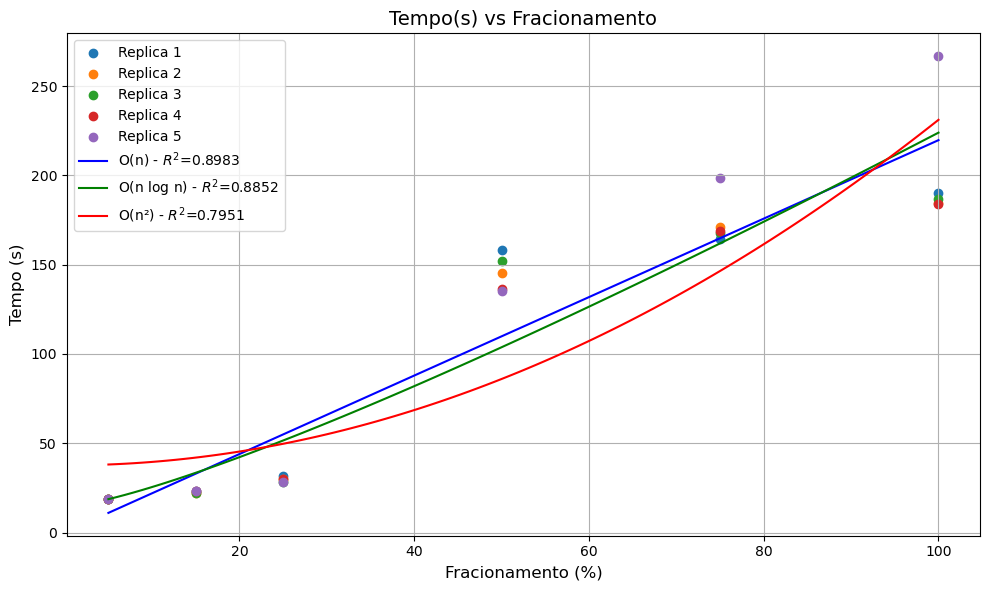

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from math import log2

# Criar a coluna 'Fracionamento_Num'
df['Fracionamento_Num'] = df['Fracionamento'].str.rstrip('%').astype(float)

# Preparar os vetores
x_n = df['Fracionamento_Num'].values
x_nlogn = x_n * np.log2(x_n)
x_n2 = x_n**2
y = df['Tempo(s)'].values

# Fun√ß√£o para ajustar e calcular R¬≤
def ajustar_e_calcular_r2(x, y):
    slope, intercept, r_value, _, _ = linregress(x, y)
    r_squared = r_value**2
    return slope, intercept, r_squared

# Ajustes
slope_n, intercept_n, r2_n = ajustar_e_calcular_r2(x_n, y)
slope_nlogn, intercept_nlogn, r2_nlogn = ajustar_e_calcular_r2(x_nlogn, y)
slope_n2, intercept_n2, r2_n2 = ajustar_e_calcular_r2(x_n2, y)

# Plotar os dados
plt.figure(figsize=(10, 6))
for replica in df['R√©plica'].unique():
    replica_data = df[df['R√©plica'] == replica]
    plt.scatter(replica_data['Fracionamento_Num'], replica_data['Tempo(s)'], label=f'Replica {replica}')

# Linhas de regress√£o
x_line = np.linspace(min(x_n), max(x_n), 100)
plt.plot(x_line, slope_n * x_line + intercept_n, label=f'O(n) - $R^2$={r2_n:.4f}', color='blue')
plt.plot(x_line, slope_nlogn * x_line * np.log2(x_line) + intercept_nlogn, label=f'O(n log n) - $R^2$={r2_nlogn:.4f}', color='green')
plt.plot(x_line, slope_n2 * x_line**2 + intercept_n2, label=f'O(n¬≤) - $R^2$={r2_n2:.4f}', color='red')

# T√≠tulo e eixos
plt.title('Tempo(s) vs Fracionamento', fontsize=14)
plt.xlabel('Fracionamento (%)', fontsize=12)
plt.ylabel('Tempo (s)', fontsize=12)

# Legenda e layout
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



/usr/local/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1797: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


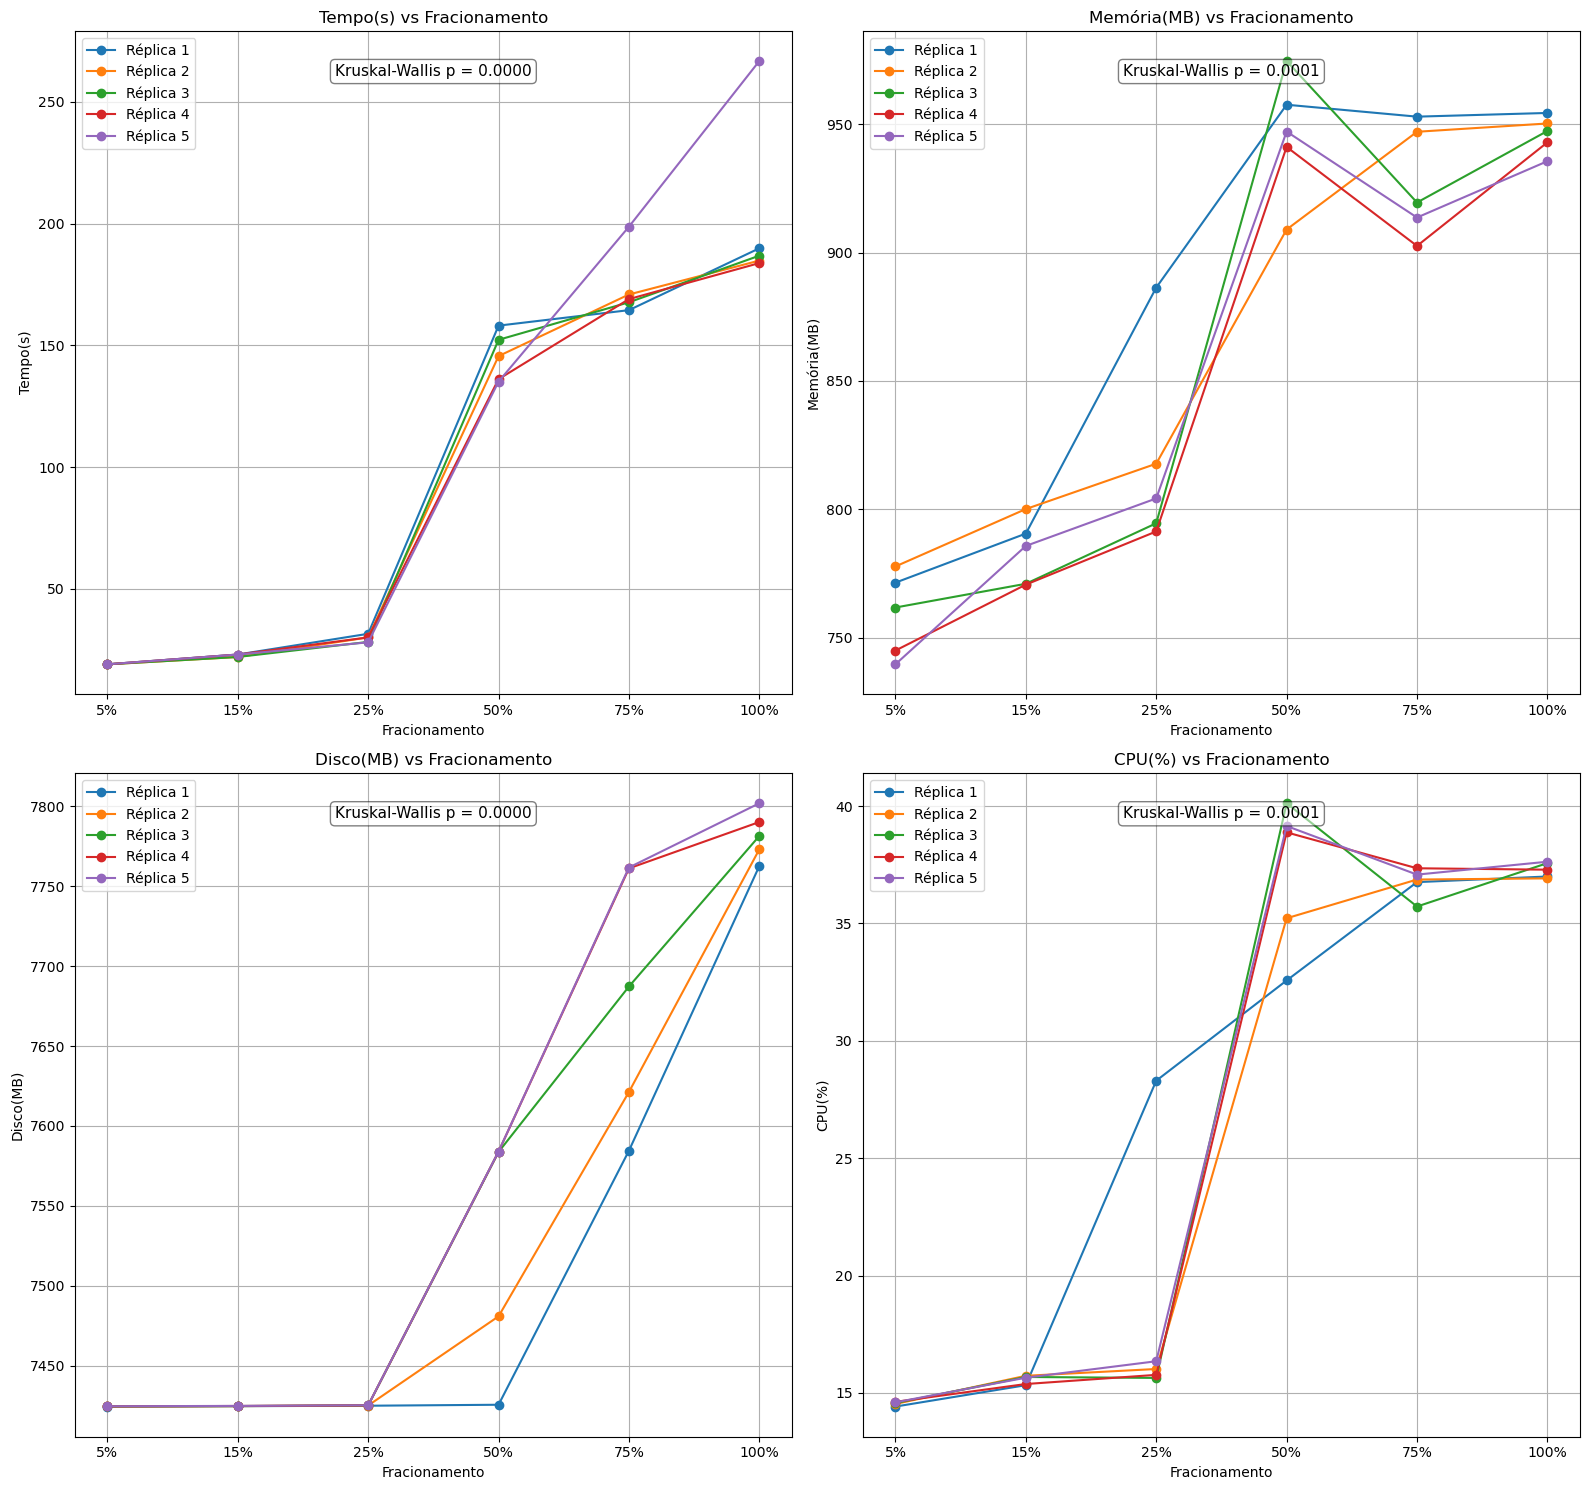

In [ ]:
metrics = ['Tempo(s)','Mem√≥ria(MB)','Disco(MB)','CPU(%)']
fracs = df['Fracionamento'].unique()

fig, axs = plt.subplots(len(metrics) // 2 + len(metrics) % 2, 2, figsize=(16, 5 * (len(metrics) // 2 + 1)))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    ax = axs[i]

    # Gr√°fico de linha por r√©plica
    for replica in df['R√©plica'].unique():
        replica_data = df[df['R√©plica'] == replica]
        ax.plot(replica_data["Fracionamento"], replica_data[metric], marker='o', label=f"R√©plica {replica}")

    ax.set_title(f"{metric} vs Fracionamento")
    ax.set_xlabel("Fracionamento")
    ax.set_ylabel(metric)
    ax.grid(True)

    # Teste estat√≠stico (ANOVA se normal, sen√£o Kruskal-Wallis)
    groups = [df[df['Fracionamento'] == f][metric] for f in fracs]
    
    # Teste de normalidade para cada grupo
    normal = all(shapiro(g)[1] > 0.05 for g in groups if len(g) >= 3)
    
    if normal:
        stat, pval = f_oneway(*groups)
        test_name = "ANOVA"
    else:
        stat, pval = kruskal(*groups)
        test_name = "Kruskal-Wallis"
    
    ax.text(0.5, 0.95, f"{test_name} p = {pval:.4f}", transform=ax.transAxes,
            fontsize=11, verticalalignment='top', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    ax.legend()

# Remove gr√°fico extra se n√∫mero de m√©tricas for √≠mpar
if len(metrics) % 2 != 0:
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()

In [104]:

for metric in metrics:
    print(f"\nüîé Analisando: {metric}")
    
    # Separar os dados por fracionamento
    groups = [df[df['Fracionamento'] == frac][metric] for frac in df['Fracionamento'].unique()]
    
    # Kruskal-Wallis
    stat, p = kruskal(*groups)
    print(f"  ‚û§ Kruskal-Wallis p-valor = {p:.5f}")
    
    if p < 0.05:
        print("  ‚û§ Diferen√ßa significativa detectada. Executando Dunn's test...")
        
        # Teste de Dunn com corre√ß√£o de Bonferroni
        dunn = sp.posthoc_dunn(df, val_col=metric, group_col='Fracionamento', p_adjust='bonferroni')
        
        # Mostrar apenas os pares com signific√¢ncia estat√≠stica
        sig_pairs = []
        for i in dunn.index:
            for j in dunn.columns:
                if i < j and dunn.loc[i, j] < 0.05:
                    sig_pairs.append((i, j, dunn.loc[i, j]))

        if sig_pairs:
            for a, b, pval in sig_pairs:
                print(f"    ‚Ä¢ Diferen√ßa significativa entre {a} e {b} (p = {pval:.5f})")
        else:
            print("    ‚Ä¢ Nenhum par significativo detectado ap√≥s corre√ß√£o.")
    else:
        print("  ‚û§ Nenhuma diferen√ßa estatisticamente significativa.")


üîé Analisando: Tempo(s)
  ‚û§ Kruskal-Wallis p-valor = 0.00004
  ‚û§ Diferen√ßa significativa detectada. Executando Dunn's test...
    ‚Ä¢ Diferen√ßa significativa entre 100% e 15% (p = 0.00821)
    ‚Ä¢ Diferen√ßa significativa entre 100% e 5% (p = 0.00020)
    ‚Ä¢ Diferen√ßa significativa entre 5% e 75% (p = 0.00271)

üîé Analisando: Mem√≥ria(MB)
  ‚û§ Kruskal-Wallis p-valor = 0.00015
  ‚û§ Diferen√ßa significativa detectada. Executando Dunn's test...
    ‚Ä¢ Diferen√ßa significativa entre 100% e 15% (p = 0.04303)
    ‚Ä¢ Diferen√ßa significativa entre 100% e 5% (p = 0.00373)
    ‚Ä¢ Diferen√ßa significativa entre 15% e 50% (p = 0.04303)
    ‚Ä¢ Diferen√ßa significativa entre 5% e 50% (p = 0.00373)
    ‚Ä¢ Diferen√ßa significativa entre 5% e 75% (p = 0.03825)

üîé Analisando: Disco(MB)
  ‚û§ Kruskal-Wallis p-valor = 0.00003
  ‚û§ Diferen√ßa significativa detectada. Executando Dunn's test...
    ‚Ä¢ Diferen√ßa significativa entre 100% e 15% (p = 0.00492)
    ‚Ä¢ Diferen√ßa signifi

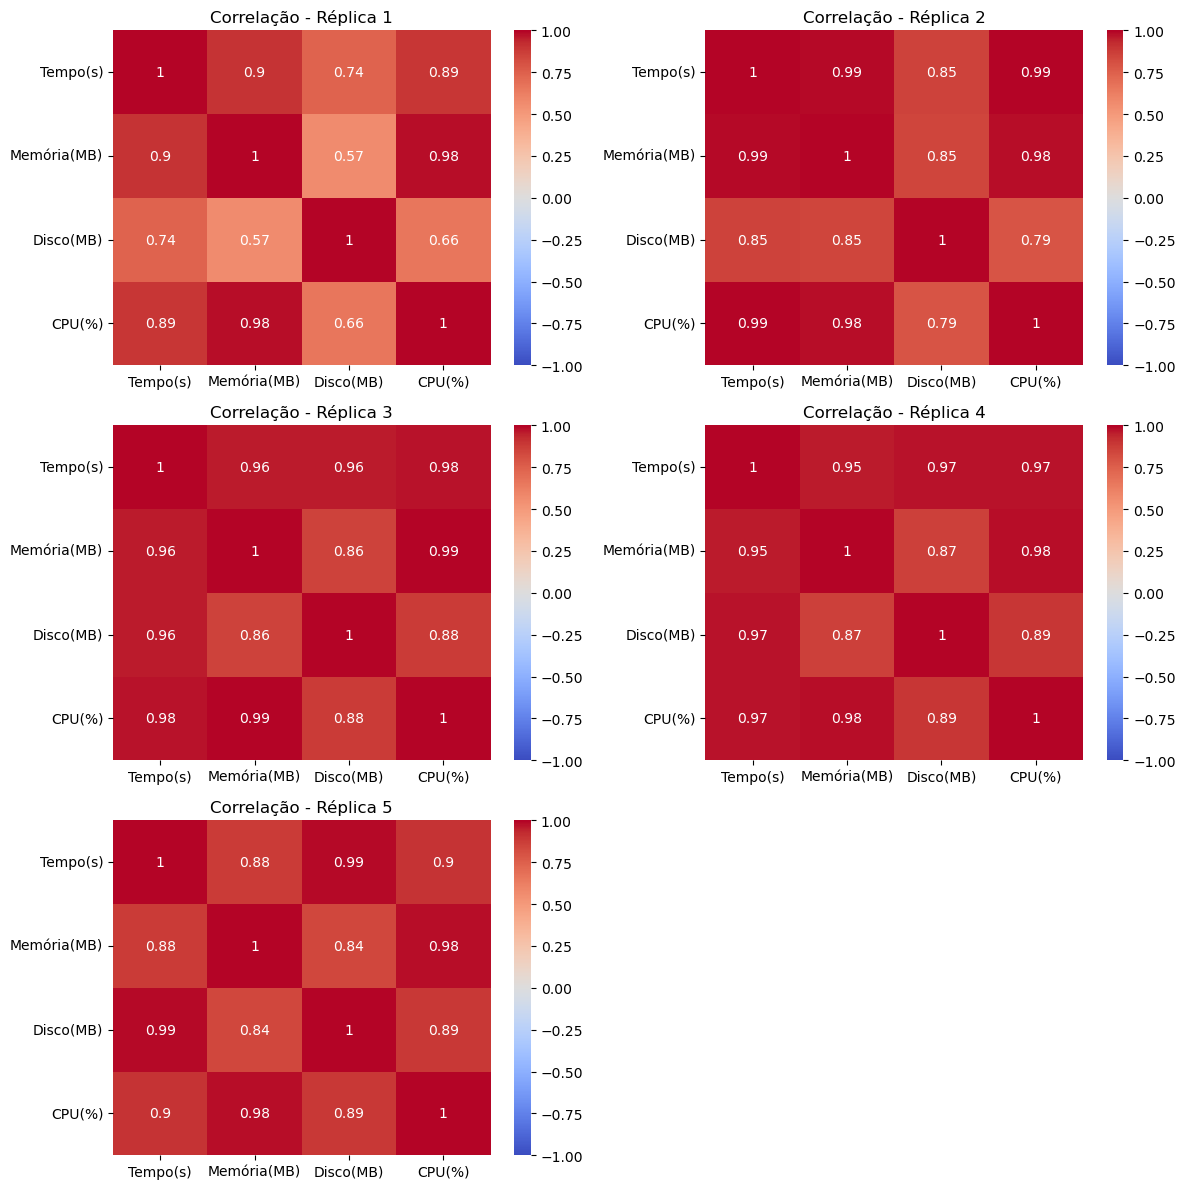

In [105]:
metrics = ['Tempo(s)', 'Mem√≥ria(MB)', 'Disco(MB)', 'CPU(%)']
replicas = df['R√©plica'].unique()

# Criar subplots com 2 colunas
ncols = 2
nrows = (len(replicas) + 1) // ncols
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
axs = axs.flatten()

for i, replica in enumerate(replicas):
    replica_data = df[df['R√©plica'] == replica][metrics]
    corr = replica_data.corr()

    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[i])
    axs[i].set_title(f'Correla√ß√£o - R√©plica {replica}')

# Se sobrar subplot vazio, remove
for j in range(len(replicas), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


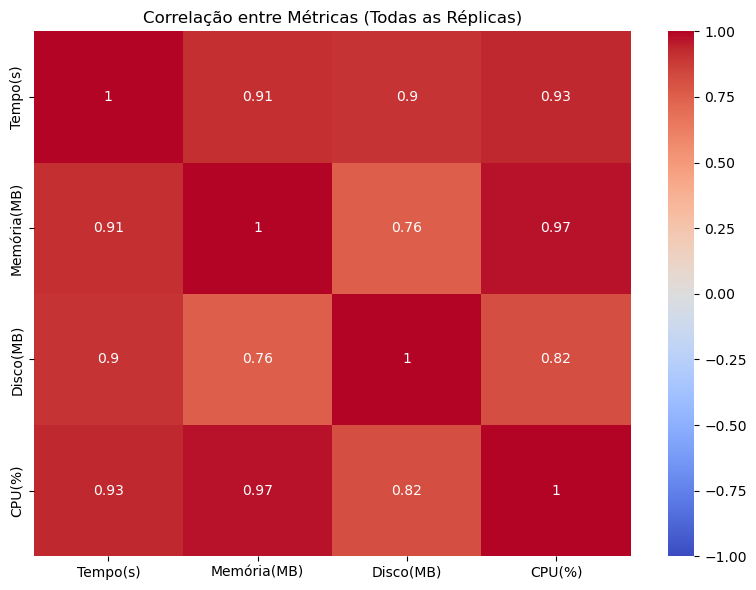

In [106]:
# Seleciona s√≥ as colunas das m√©tricas
metrics = ['Tempo(s)', 'Mem√≥ria(MB)', 'Disco(MB)', 'CPU(%)']
df_metrics = df[metrics]

# Calcula a matriz de correla√ß√£o
corr = df_metrics.corr()

# Plota o mapa de calor da correla√ß√£o
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correla√ß√£o entre M√©tricas (Todas as R√©plicas)')
plt.tight_layout()
plt.show()